# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets. 

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English. 

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text. 

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

import matplotlib.pyplot as plt


Let's get the data!

In [17]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [18]:
# Initialize tokenizer
tokenizer = Tokenizer()

# Fit tokenizer on corpus
tokenizer.fit_on_texts(corpus)

Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [19]:
total_words = len(tokenizer.word_index) + 1
print(total_words)

3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [20]:
input_sequences = []

for sentence in corpus:
    # Convert sentence to tokenized sequence
    token_list = tokenizer.texts_to_sequences([sentence])[0]
    
    # Generate n-gram sequences
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
    

Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [21]:
# Calculate max sequence length
max_sequence_len = max(len(seq) for seq in input_sequences)

# Pad sequences
input_sequences = pad_sequences(
    input_sequences,
    maxlen=max_sequence_len,
    padding='pre'
)

# Convert to numpy array
input_sequences = np.array(input_sequences)

Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [22]:
predictors = input_sequences[:, :-1]
labels = input_sequences[:, -1]

One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors. 

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [23]:
labels = ku.to_categorical(labels, num_classes=total_words)


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [24]:
model = Sequential([
    
    # Embedding Layer
    Embedding(
        input_dim=total_words,
        output_dim=100,
        input_length=max_sequence_len - 1
    ),

    # LSTM layer
    Bidirectional(
        LSTM(150, return_sequences=True)
    ),

    # Dropout layer
    Dropout(0.2),

    # Second LSTM
    LSTM(100),

    # Intermediate Dense
    Dense(
        total_words // 2,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01)
    ),

    # Output Dense
    Dense(
        total_words,
        activation='softmax'
    )
])

c:\Users\santi\devtools\anaconda3\envs\ironhack\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [25]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [26]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [27]:
history = model.fit(
    predictors,
    labels,
    epochs=75,
    verbose=1
)

Epoch 1/75
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.0212 - loss: 6.9173
Epoch 2/75
484/484 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0237 - loss: 6.5080
Epoch 3/75
484/484 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0243 - loss: 6.4202
Epoch 4/75
484/484 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0291 - loss: 6.3223
Epoch 5/75
484/484 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0340 - loss: 6.2315
Epoch 6/75
484/484 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0379 - loss: 6.1561
Epoch 7/75
484/484 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0408 - loss: 6.0863
Epoch 8/75
484/484 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0444 - loss: 6.0099
Epoch 9/75
484/484 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0465 - loss: 5.9251
Epoch 10/75
484/484 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0501 - loss: 5.8414
Epoch 11/75
484/484 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0566 - loss: 5.7501
Epoch 12/75
484/484 ━━━━━━━━━━━━━━━━━━━━ 

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

In [28]:
import matplotlib.pyplot as plt

# check names of metrics
print(history.history.keys())

dict_keys(['accuracy', 'loss'])


In [29]:
# get metrics
accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(accuracy) + 1)

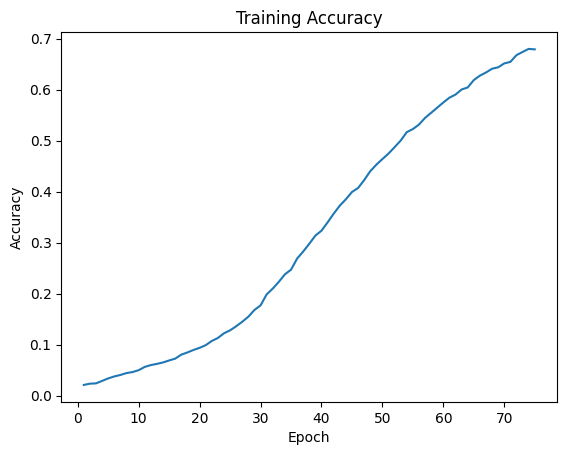

In [30]:
# accuracy plot
plt.figure()
plt.plot(epochs, accuracy)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

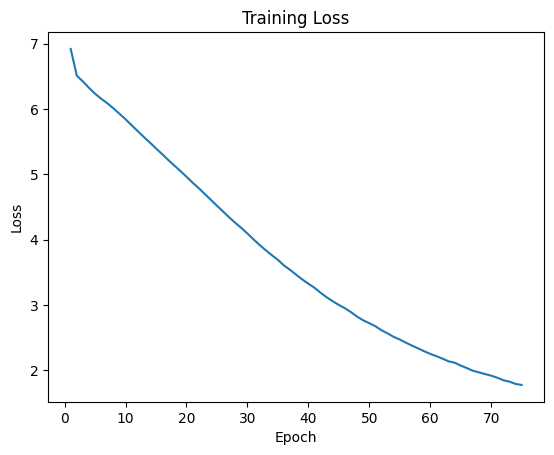

In [31]:
# loss plot
plt.figure()
plt.plot(epochs, loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [ ]:
seed_text_start_1 = "shall i compare thee to a summer's day"
seed_text_start_2 = "thou wert the mirror wherein I beheld myself"
seed_text_start_3 = "the cats do remember thee"
seed_text_start_4 = "how many mournings must there be?"

Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [45]:
# function to create text

def create_text(seed_text, next_words=10, temperature=0.7, top_k=None, top_p=None):
    
    for _ in range(next_words):
        
        # Convert seed text to token sequence
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        
        # Pad to required input length
        token_list = pad_sequences(
            [token_list],
            maxlen=max_sequence_len - 1,
            padding='pre'
        )
        
        # Predict next word probabilities
        predicted_probs = model.predict(token_list, verbose=0)[0]
        
        # CHOOSING WORD 
        # hyperparameters
        temperature = 1.0     # <1 más determinista, >1 más creativo
        top_k = 20            # None para desactivar
        top_p = 0.9           # None para desactivar (ej: 0.9)
        
        # apply temperature
        probs = predicted_probs
        probs = np.log(probs + 1e-9) / temperature
        probs = np.exp(probs)
        probs = probs / np.sum(probs)

        #apply top k
        if top_k is not None:
            indices = np.argsort(probs)[-top_k:]
            probs_top_k = probs[indices]
            probs_top_k = probs_top_k / np.sum(probs_top_k)
        else:
            indices = np.arange(len(probs))
            probs_top_k = probs

        # apply top p
        if top_p is not None:
            sorted_indices = indices[np.argsort(probs_top_k)[::-1]]
            sorted_probs = probs[sorted_indices]
            cumulative_probs = np.cumsum(sorted_probs)

            cutoff = cumulative_probs <= top_p
            if not np.any(cutoff):
                cutoff[0] = True  # asegurar al menos una opción
            
            filtered_indices = sorted_indices[cutoff]
            filtered_probs = probs[filtered_indices]
            filtered_probs = filtered_probs / np.sum(filtered_probs)
        else:
            filtered_indices = indices
            filtered_probs = probs_top_k

        # final sampling
        predicted_index = np.random.choice(filtered_indices, p=filtered_probs)


        # Convert index back to word
        output_word = tokenizer.index_word.get(predicted_index, "")
        
        # Append predicted word to seed_text
        seed_text += " " + output_word

    # Print final generated text
    return(seed_text)


Experiment with at least 3 different seed_text strings and see what happens!

In [48]:
generated_1 = create_text(seed_text_start_1)
generated_2 = create_text(seed_text_start_2)
generated_3 = create_text(seed_text_start_3)
generated_4 = create_text(seed_text_start_4)
generated_5 = create_text(seed_text_start_5)

In [49]:
print(generated_1)

shall i compare thee to a summer's day alone view ' be thine own heart is thee in


In [50]:
print(generated_2)

thou wert the mirror wherein I beheld myself chide thee none lies worth back ye worth thee glory


In [51]:
print(generated_3)

the cats do remember thee from thy breast doth blind dead prove thee ill new


In [53]:
print(generated_4)

the two little creatures do remember thee delights so woe of decay tend gone strange 'amen' '
